In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tkinter as tk
import random
from PIL import Image
from numpy import asarray

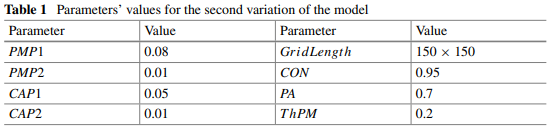

1. Initialiser le modèle : 
    Les paramètres des équations de diffusion sont défini et la topologie des points de départ et des sources de nourriture est introduit grâce à un array depuis une image
2. 
    Appliquer les équations de diffusion pendant 50 itérations (t)
3. 
    Vérifier si les sources de nourritures sont couvertes avec un pourcentage prédéfini de masse du slime
    Si au moins une source de nourriture est couverte :
        Continuer
    Si aucune source de nourriture n'est couverte : 
        Retourner à l'étape 2
4. 
    Toutes les sources de nourriture couvertes avec le pourcentage prédéfini de masse de slime sont encapsulés par le plasmodium et sont donc connectées à un point de départ
5. 
    Les sources de nourritures mentionnées à l'étape 4 se transforment en point de départ, ce qui veut dire que leur masse de slime est définie à 100.
    S'il y a eu moins de 5000 itérations : 
        Retourner à l'étape 2
    Sinon :
        Continuer
6. 
    Redéfinir les cellules "d'intéret" (points de départ et sources de nourriture) en tant que sources de nourriture, sauf les trois dernières sources de nourriture encapsulées dans les 5000 dernières itérations, ceux-ci sont transformés en point de départ

    Répéter les étapes 2 à 5 pour 5000 itérations.

Au départ de l'algorithme : 
    PM (masse de slime) vaut : 
        0 si la case n'est pas une case accessible
        100 si la case est un point de départ
        100 si la case est une source de nourriture ET que la masse de slime sur cette case est supérieure au pourcentage de masse nécessaire prédefini

In [10]:
#Constantes : 
PAP = 0
CON = 0.95
thPM = 0.2 #Masse de slime minimale sur source de nourriture pour qu'il fasse parti du réseau, donnée à modifier
PMP1 = 0.08
PMP2 = 0.01
CAP1 = 0.05
CAP2 = 0.01

def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

class Cell:
    #cell[i,j] = (Espacelibre, MasseSlime, MasseFood, DA, Tube (si la cellule fait partie d'un tube ou non))
    def __init__(self, dispo = 0, mass = float(0), CHA = float(0), da = 0, tube = False, food = False, slime = False, count = 0):
        self.dispo = dispo #la cellule est dispo ou non, 0 ou 1
        self.mass = None #masse du slime présente sur la cellule
        self.CHA = None #attractivité de la nourriture sur notre cellule CHemoAttractant en pourcentage
        self.da = da #direction entre 0 et 8, 0 si pas de direction, va vers le voisin avec la plus grande mass de slime
        self.tube = tube #la cellule est un tube ou non, bool
        self.food = food #si la cellule est un NS "nutrient source"
        self.slime = slime #si la cellule est un SP "starting point"
        self.color = None #code hexa de la couleur associée à la cellule
        self.refresh(mass, CHA)

        
        #l'état d'une cellule ne prendra pas en compte la direction
    
    def calculate_color(self):
        """
        définit la "couleur" d'une cellule pour sa représentation tkinter, retourne le code hexadecimal de la couleur, on voudra un degradé du blanc vers le jaune pour la concentration de slime sur une cellule
        """
        couleur = rgb_to_hex(0,0,0)
        ech = max(0, min(100, self.mass)) #on échelonne de 0 à 100 pour la masse de slime
        degrade = int(255 * (100 - ech) / 100)

        if self.mass != 0:
            couleur = rgb_to_hex(255,255,degrade) #cellule avec du slime - degradé de blanc à jaune
        elif self.CHA != 0:
            couleur = rgb_to_hex(0,0,255) #cellule avec "odeur" de nourriture
        elif self.dispo == 1:
            couleur = rgb_to_hex(255,255,255) #cellule vide
        
        return couleur #cellule mur

    
    def refresh(self, mass, cha):
        self.mass = mass
        self.CHA = cha
        self.color = self.calculate_color()



    def __repr__(self):
        
        if self.mass != 0:
            return "2" #cellule avec du slime
        elif self.CHA != 0:
            return "3" #cellule avec "odeur" de nourriture
        elif self.dispo == 1:
            return "1" #cellule vide
        
        return "0"     #cellule mur
        
PA_WEST = 0
PA_SOUTH = 0
PA_EAST = 0
PA_NORTH = 0
PA_SOUTHWEST = 0
PA_SOUTHEAST = 0
PA_NORTHEAST = 0
PA_NORTHWEST = 0

class Map:
    def __init__(self, imName, diffSlime1, diffSlime2, diffNour1, diffNour2, step_diff = 50):

        self.diffSlime1=diffSlime1     #parametre 1 de l'équation de diffusion du slime
        self.diffSlime2=diffSlime2     #parametre 2 de l'équation de diffusion du slime
        self.diffNour1=diffNour1       #parametre 1 de l'équation de diffusion de la nourriture
        self.diffNour2=diffNour2       #parametre 2 de l'équation de diffusion de la nourriture
        self.imName = imName           #nom du fichier de l'image
        self.image = self.imToMat(self.imName)
        self.grid = self.normalise(self.image)
        self.height = len(self.grid)
        self.width = len(self.grid[0])
        self.t = 0
        self.step_diff = step_diff
        self.last_three_encapsulated = []

        #self.grid[i][j] = 0 if i<0 or i>=len(self.height) or j<0 or j>=len(self.width) else self.grid[i][j]

        
        
    def __str__(self):
        return str(self.grid)
    
    @staticmethod
    def imToMat(imName):
        im = Image.open(imName + '.png')
        matrice = asarray(im)
        #print(matrice.shape)   #forme de l'array
        #return im
        return matrice
    
    @staticmethod
    def normalise(arrayIm):
        """
        arrayIm de taille (x, y, z=valeur rgb), on veut return une matrice de taille (x, y), première étape
        """
        x, y, _ = arrayIm.shape
        newArray = []

        for i in range(x):
            row = []
            for j in range(y):
                if ((arrayIm[i][j][0] == 0) and (arrayIm[i][j][1] == 0) and (arrayIm[i][j][2] == 0)):  # noir
                    row.append(Cell(dispo=0) ) #représente un mur
                elif arrayIm[i][j][0] == 255 and arrayIm[i][j][1] == 255 and arrayIm[i][j][2] == 255:  # blanc
                    row.append(Cell(dispo=1))  #est un espace libre
                elif arrayIm[i][j][0] == 255 and arrayIm[i][j][1] == 255 and arrayIm[i][j][2] == 0:  # jaune
                    row.append(Cell(dispo=1, mass=100, slime=True))  #représente une cellule du slime
                elif arrayIm[i][j][0] == 0 and arrayIm[i][j][1] == 0 and arrayIm[i][j][2] == 255:  # bleu
                    row.append(Cell(dispo=1, CHA=100, food=True))  #source de nourriture
            newArray.append(row)
        return newArray
    
    def val_CHA(self, i, j):
        """
        retourne la valeur de CHA si dans la grid, 0 sinon permet de bypass sortie de boucle dans calcul_PA
        """

        if i<0 or i>=self.height or j<0 or j>=self.width:
            return 0
        else:
            return self.grid[i][j].CHA

        
    def calcul_PA(self, i, j):


        CHAvoisins = [
            self.val_CHA(i,j-1),    #W
            self.val_CHA(i+1,j),    #S
            self.val_CHA(i,j+1),    #E
            self.val_CHA(i-1,j),    #N
            self.val_CHA(i+1,j-1),  #SW
            self.val_CHA(i+1,j+1),  #SE
            self.val_CHA(i-1,j+1),  #NE
            self.val_CHA(i-1,j-1),  #NW
            ]
        
        PA_WEST = 0
        PA_SOUTH = 0
        PA_EAST = 0
        PA_NORTH = 0
        PA_SOUTHWEST = 0
        PA_SOUTHEAST = 0
        PA_NORTHEAST = 0
        PA_NORTHWEST = 0

        if CHAvoisins[3] == max(CHAvoisins):
            PA_NORTH = PAP
            PA_SOUTH = -PAP

        elif CHAvoisins[1] == max(CHAvoisins):
            PA_SOUTH = PAP
            PA_NORTH = -PAP
        elif CHAvoisins[2] == max(CHAvoisins):
            PA_EAST = PAP
            PA_WEST = -PAP
        elif CHAvoisins[0] == max(CHAvoisins):
            PA_WEST = PAP
            PA_EAST = -PAP
        elif CHAvoisins[7] == max(CHAvoisins):
            PA_NORTHWEST = PAP
            PA_SOUTHEAST = -PAP
        elif CHAvoisins[4] == max(CHAvoisins):
            PA_SOUTHWEST = PAP
            PA_NORTHEAST = -PAP
        elif CHAvoisins[6] == max(CHAvoisins):
            PA_NORTHEAST = PAP
            PA_SOUTHWEST = -PAP
        elif CHAvoisins[5] == max(CHAvoisins):
            PA_SOUTHEAST = PAP
            PA_NORTHWEST = -PAP

        return (PA_WEST,PA_SOUTH, PA_EAST, PA_NORTH, PA_SOUTHWEST, PA_SOUTHEAST, PA_NORTHEAST, PA_NORTHWEST,)

        
        
    def inMap(self, i, j):
        """
        Vérifie si la case [i][j] existe dans la matrice donnée. Retourne True si la case existe, sinon False
        """
        if i < 0 or i >= self.height or j < 0 or j >= self.width:
            return False  # La case est en dehors des limites de la map
        
        return True  # La case existe
    
    def PMvNN(self, i, j):
            """
            Contribution du voisinage de von Neumann pour la masse du slime sur cellule [i][j]
            """
            haut = 0
            gauche = 0
            bas = 0
            droit = 0
            self.calcul_PA(i,j)
            
            if self.grid[i][j].dispo == 1: #Vérifie juste qu'on est pas sur un mur. Si c'est le cas la contribution doit être nulle
                if self.inMap(i-1,j):
                    haut   = (1 + PA_NORTH) * self.grid[i-1][j].mass - (self.grid[i-1][j].dispo * self.grid[i][j].mass)
                if self.inMap(i,j-1):
                    gauche = (1 + PA_WEST) * self.grid[i][j-1].mass - (self.grid[i][j-1].dispo * self.grid[i][j].mass)
                if self.inMap(i+1,j):
                    bas    = (1 + PA_SOUTH) * self.grid[i+1][j].mass - (self.grid[i+1][j].dispo * self.grid[i][j].mass)
                if self.inMap(i,j+1):
                    droit  = (1 + PA_EAST) * self.grid[i][j+1].mass - (self.grid[i][j+1].dispo * self.grid[i][j].mass)
                
                #print("contribution PA von Neumann : ",(haut + gauche + droit + bas))
            total = haut + gauche + droit + bas
            return total

    def PMeMN(self, i, j):
        """"
        Contribution du voisinage de Moore pour la masse du slime sur cellule [i][j]
        """
        hautgauche=0
        basgauche=0
        hautdroit=0
        basdroit=0
        
        if self.grid[i][j].dispo == 1:
            if self.inMap(i-1,j-1):
                hautgauche = (1 + PA_NORTHWEST) * self.grid[i-1][j-1].mass - (self.grid[i-1][j-1].dispo * self.grid[i][j].mass)
            if self.inMap(i+1,j-1):
                basgauche  = (1 + PA_SOUTHWEST) * self.grid[i+1][j-1].mass - (self.grid[i+1][j-1].dispo * self.grid[i][j].mass)
            if self.inMap(i-1,j+1):
                hautdroit  = (1 + PA_NORTHEAST) * self.grid[i-1][j+1].mass - (self.grid[i-1][j+1].dispo * self.grid[i][j].mass)
            if self.inMap(i+1,j+1):
                basdroit   = (1 + PA_SOUTHEAST) * self.grid[i+1][j+1].mass - (self.grid[i+1][j+1].dispo * self.grid[i][j].mass)
            
            #print("contribution PA moore : ",(hautgauche + hautdroit + basgauche + basdroit))
        total = hautgauche + hautdroit + basgauche + basdroit  
        return total
    
    def PM(self, i, j):
        """
        masse de slime totale à t+1 sur la case [i][j]
        """
        #print("masse sur la case {} {} = ".format(i,j), self.grid[i][j].mass)
        #print("mass : {}, PMvNN : {}, PMeMN : {}".format(self.grid[i][j].mass,self.PMvNN(i, j),self.PMeMN(i, j)))
        return self.grid[i][j].mass + self.diffSlime1 * (self.PMvNN(i, j) + self.diffSlime2 * self.PMeMN(i, j))
    
    def CHAvNN(self, i, j):
        """
        Contribution du voisinage de von Neumann pour la diffusion du chemoattractant sur la case [i][j]
        """
        haut = 0
        gauche = 0
        bas = 0
        droit = 0
        
        if self.grid[i][j].dispo == 1: #Vérifie juste qu'on est pas sur un mur. Si c'est le cas la contribution doit être nulle
            if self.inMap(i-1,j):
                haut   = self.grid[i-1][j].CHA - (self.grid[i-1][j].dispo * self.grid[i][j].CHA)
            if self.inMap(i,j-1):
                gauche = self.grid[i][j-1].CHA - (self.grid[i][j-1].dispo * self.grid[i][j].CHA)
            if self.inMap(i+1,j):
                bas    = self.grid[i+1][j].CHA - (self.grid[i+1][j].dispo * self.grid[i][j].CHA)
            if self.inMap(i,j+1):
                droit  = self.grid[i][j+1].CHA - (self.grid[i][j+1].dispo * self.grid[i][j].CHA)

        #print("contribution CHA von Neumann : ",(haut + gauche + droit + bas))
        total = haut + gauche + droit + bas
        return total

    def CHAeMN(self, i, j):
        """
        Contribution du voisinage de Moore pour la diffusion du chemoattractant sur la case [i][j]
        """
        hautgauche = 0
        hautdroit = 0
        basgauche = 0
        basdroit = 0
        
        if self.grid[i][j].dispo == 1: #Vérifie juste qu'on est pas sur un mur. Si c'est le cas la contribution doit être nulle
            if self.inMap(i-1,j-1):
                hautgauche = (self.grid[i-1][j-1].CHA) - (self.grid[i-1][j-1].dispo * self.grid[i][j].CHA)
            if self.inMap(i+1,j-1):
                hautdroit  = (self.grid[i+1][j-1].CHA) - (self.grid[i+1][j-1].dispo * self.grid[i][j].CHA)
            if self.inMap(i-1,j+1):
                basgauche  = (self.grid[i-1][j+1].CHA) - (self.grid[i-1][j+1].dispo * self.grid[i][j].CHA)
            if self.inMap(i+1,j+1):
                basdroit   = (self.grid[i+1][j+1].CHA) - (self.grid[i+1][j+1].dispo * self.grid[i][j].CHA)

        #print("contribution CHA moore : ",(hautgauche + hautdroit + basgauche + basdroit))
        total = hautgauche + hautdroit + basgauche + basdroit
        return total

    def CHA(self, i, j):
        """
        Attraction chimique sur la case [i][j] à t+1
        """
        #print("CHA : {}, CHAvNN : {}, CHAeMN : {}".format(self.grid[i][j].CHA,self.CHAvNN(i, j),self.CHAeMN(i, j)))
        return CON * ( self.grid[i][j].CHA + self.diffNour1 * ( self.CHAvNN(i, j) + self.diffNour2 * self.CHAeMN(i, j) ) )

    def diffusionMap(self):
        """
        applique les équations de diffusions sur toute la map pour 1 itération
        """
        i=0
        j=0
        for i in range(self.height):
            for j in range(self.width):
                self.grid[i][j].refresh(self.PM(i,j), self.CHA(i, j))
                if self.grid[i][j].food == True and self.grid[i][j].mass >= thPM:
                        self.last_three_encapsulated.append((i,j,))
                        self.last_three_encapsulated = self.last_three_encapsulated[-3:]
                        
        #print("type de self.grid[i][j].CHA : ", type(self.grid[i][j].CHA))
        #print("type de self.grid[i][j].mass : ", type(self.grid[i][j].mass))

    def afficheMapSlime(self):
        """
        Représentation visuelle des masses de slime sur la map
        """
        row=[]
        col=[]
        for i in range(self.height):
            for j in range(self.width):
                row.append(self.grid[i][j].mass)
            col.append(row)
            row=[]
        print(col)

        #print([[obj.mass for obj in row] for row in self.grid])

    def afficheMapCHA(self):
        """
        Représentation visuelle des CHA sur la map
        """
        row=[]
        col=[]
        for i in range(self.height):
            for j in range(self.width):
                row.append(self.grid[i][j].CHA)
            col.append(row)
            row=[]
        print(col)

    def start_loop(self):
        """
        boucle principale de la Map, se charge de faire tous les traitements
        """
        is_end = False 
        while not is_end:
            self.afficheMapSlime()
            self.iterate_diff()
            print("t : ", self.t)
            for i in range(self.height):
                for j in range(self.width):
                    if self.grid[i][j].food == True and self.grid[i][j].mass >= thPM:
                        self.grid[i][j].food = False
                        self.grid[i][j].slime = True

            if self.t == 5000: #redéfinir les POI
                for i in range(self.height):
                    for j in range(self.width):  
                        if not (i,j,) in self.last_three_encapsulated:
                            self.grid[i][j].food = True
                            self.grid[i][j].slime = False

            elif self.t >= 10000:
                is_end = True


    def iterate_diff(self):
            """
            itère diffusionMap pour step_diff itérations
            """
            for i in range(self.step_diff):
                self.diffusionMap()
                self.t += 1

class FenetreBlob(tk.Tk):
    def __init__(self, map):
        super().__init__()

        self.map = map


        self.title("Simulation blob")
        self.geometry("1920x1080")
        self.widget()

        self.canvas = tk.Canvas(self, width=10*(self.map.width), height=10*(self.map.height), background = "red")
        self.canvas.grid = self.canvas.grid(column=0, row=0, sticky=("W"))
        self.canvas.pack()
        self.display()
        
        self.const.pack()
        self.exec.pack()
        self.stop.pack()
        
    def widget(self):
        self.const = tk.Label(self, text = "Constantes : ")
        self.exec = tk.Button(self, text = "Executer")
        self.stop = tk.Button(self, text = "STOP")


    def display(self): #à modifier ?
        """Affiche la Map"""
        cell_width = 10
        cell_height = 10    #pour que chaque cellule fasse du 10x10px
        for y, row in enumerate(self.map.grid):
            for x, cell in enumerate(row):
                if cell.dispo == 1 and cell.slime:
                    color = "yellow"
                elif cell.dispo == 1 and cell.food:
                    color = "blue"
                elif cell.dispo == 1 and not cell.food and not cell.slime:
                    color = "white"
                else:
                    color = "black"
                self.canvas.create_rectangle(x * cell_width, y * cell_height,
                                             (x + 1) * cell_width, (y + 1) * cell_height,
                                             fill=color, outline=color)



def main():
    map_obj = Map("test", diffSlime1=PMP1, diffSlime2=PMP2, diffNour1=CAP1, diffNour2=CAP2)
    root = tk.Tk()
    #app = FenetreBlob(map_obj)
    #app.mainloop()



if __name__ == "__main__":
    main()

#mat = normalise(ImToMat("test"))
map_obj = Map("test", diffSlime1=PMP1, diffSlime2=PMP2, diffNour1=CAP1, diffNour2=CAP2)
print(type(map_obj.grid[0][0]))
#print(map_obj.PA(0,8,0,7))
#print(map_obj.PM(1,7))
#print(map_obj.CHA(0,9))
map_obj.start_loop()
"""
map_obj.afficheMapSlime() #iteration 0
for i in range(100):
    map_obj.iterate_diff()

map_obj.afficheMapSlime()
"""


<class '__main__.Cell'>
[[0.0, 0.0, 100, 0.0, 100, 100, 0.0, 100, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 100, 100, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]
t :  50
[[5.983613970457336, 0.0, 32.68806242784782, 45.554863272817265, 55.154738030075336, 55.04079519365254, 45.38191321800827, 32.59405768182728, 0.0, 6.406056841497965], [7.482676164777035, 11.141318042706938, 18.251938642896196, 0.0, 60.11870559849743, 59.922745886504224, 0.0, 18.36463322131396, 11.377098187657143, 7.861481979647245], [6.466397751909044, 8.288209069178153, 10.789736183162638, 0.0, 0.0, 0.0, 0.0, 10.950487230074451, 8.53456187417

'\nmap_obj.afficheMapSlime() #iteration 0\nfor i in range(100):\n    map_obj.iterate_diff()\n\nmap_obj.afficheMapSlime()\n'